### Exploratory Analysis of Stack Overflow Survey Data

#### Broadly speaking, we are interested in answering the following questions: 

1. How does remote vs. office work relate to salary?
2. How does remote vs. office work relate to job/career satisfaction?
3. What if any factors can predict attitudes about diversity in the workplace?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import seaborn as sns
import os
import pprint
import column_rename_dicts as crd
%matplotlib inline
pd.options.display.max_seq_items = 500

In [3]:
#regex patterns needed in data cleaning
date_pattern = r"^([1-9]|1[012])[- /.]([1-9]|[12][0-9]|3[01])[- /.](19|20)\d\d$"

In [116]:
def collapse_cat_and_dummy(value_str, value_list):
    '''
    INPUT
        HomeRemoteStr - a string of one of the values from the column of interest

    OUTPUT
        return 1 if the string is in value_list
        return 0 otherwise
    '''
    if value_str in value_list:
        return 1
    else:
        return 0 

In [59]:
def get_description(column_name, schema=schema_2017):
    '''
    INPUT - schema - pandas dataframe with the schema of the developers survey
            column_name - string - the name of the column you would like to know about
    OUTPUT - 
            desc - string - the description of the column
    '''
    desc = schema['Question'][schema['Column']==column_name].values[0]
    return desc

In [60]:
def df_missingness_stats(df, year):
    df.name = year + ' data'
    print('Number of Rows in {}: {}'.format(df.name, df.shape[0]))
    print('Number of Columns in {}: {}'.format(df.name, df.shape[1]))
    print('Number of Columns in {} with no missing values: {}'.format(df.name, len(set(df.columns[~df.isnull().any()]))))
    print('Number of Columns in {} with > 75% missing values: {}'.format(df.name, 
                                                                         len(set(df.columns[df.isnull().sum()/len(df) > .75]))))
    print('Number of Columns in {} with all missing values: {}'.format(df.name, 
                                                                         len(set(df.columns[df.isnull().sum()/len(df) == 1]))))
    print('Columns in {} with no missing values: {}'.format(df.name, 
                                                            set(df.columns[~df.isnull().any()])))
    print('Columns in {} with > 75% missing values: {}'.format(df.name, 
                                                               set(df.columns[df.isnull().sum()/len(df) > .75])))

In [130]:
#Load Data
df_2017 = pd.read_csv('./so-survey-2017/survey_results_public.csv')
schema_2017 = pd.read_csv('./so-survey-2017/survey_results_schema.csv')

#### How does remote vs. office work relate to salary?

In [119]:
df_2017['HomeRemote'].value_counts(dropna=False)

A few days each month                                      15454
Never                                                      13975
NaN                                                         7384
All or almost all the time (I'm full-time remote)           4905
Less than half the time, but at least one day each week     4147
More than half, but not all, the time                       1909
It's complicated                                            1849
About half the time                                         1769
Name: HomeRemote, dtype: int64

Text(0.5, 1.0, 'Frequency of Time Spent Remote Working')

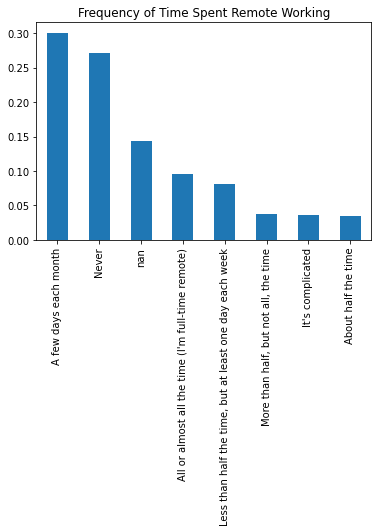

In [120]:
home_remote_value_counts = df_2017['HomeRemote'].value_counts(dropna=False)
(home_remote_value_counts/df_2017.shape[0]).plot(kind="bar")
plt.title("Frequency of Time Spent Remote Working")

In [132]:
df_2017['HomeRemote_missing'] = df_2017['HomeRemote'].isna()

In [123]:
df_2017['HomeRemote'].isnull().sum()/df_2017.shape[0]

0.1436799501867995

In [137]:
# Create different definitions for a remote worker
# Strict definition: A remote worker is one that is full-time remote
# Lax definition: A remote worker is one that spends at least one
# day a week working remotely. 
# In either case, if are implicitly imputing missing values by treating them 
# as if they were the modal response ("A few days each month"). Both defin
remote_worker_strict_list = ["All or almost all the time (I'm full-time remote)"]
remote_worker_lax_list = ["All or almost all the time (I'm full-time remote)", "Less than half the time, but at least one day each week", "More than half, but not all, the time", "About half the time"]

In [138]:
# Collapse and dummy HomeRemote and DiversityImportant columns
df_2017['RemoteWorker_Strict']=df_2017['HomeRemote'].apply(collapse_cat_and_dummy, args=(remote_worker_strict_list,))
df_2017['RemoteWorker_Lax']=df_2017['HomeRemote'].apply(collapse_cat_and_dummy, args=(remote_worker_lax_list,))

In [139]:
#Check that function works
assert df_2017['RemoteWorker_Strict'].sum() == home_remote_value_counts.filter(items=remote_worker_strict_list).sum()
assert df_2017['RemoteWorker_Lax'].sum() == home_remote_value_counts.filter(items=remote_worker_lax_list).sum()

In [127]:
remote_strict_1 = df_2017[df_2017['RemoteWorker_Strict'] == 1] # Subset df to only those with RemoteWorker_Strict of 1
remote_strict_0 = df_2017[df_2017['RemoteWorker_Strict'] == 0] # Subset df to only those with RemoteWorker_Strict of 0


#### Inspect Salary Field

In [149]:
df_2017['Salary'].value_counts(dropna=False)

NaN              38501
120000.000000      167
110000.000000      164
100000.000000      155
75000.000000       149
                 ...  
77322.000000         1
76095.025984         1
14262.132717         1
33057.851240         1
77700.000000         1
Name: Salary, Length: 3050, dtype: int64

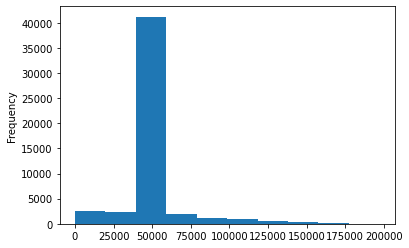

In [154]:
df_2017['Salary_Imputed'].plot(kind="hist")
plt.show()

In [152]:
df_2017['Salary_Imputed'] = df_2017['Salary'].fillna(df_2017['Salary'].mean()) #Fill all missing values with the mean of the column.

#### Inspect Job/Career Satisfaction Fields

In [144]:
df_2017['JobSatisfaction'].value_counts(dropna=False)

NaN     11016
8.0      8983
7.0      7969
9.0      5573
6.0      4726
10.0     4148
5.0      3749
4.0      1865
3.0      1635
2.0       888
0.0       467
1.0       373
Name: JobSatisfaction, dtype: int64

In [146]:
job_sat_remote_strict_1 = remote_strict_1['JobSatisfaction'].value_counts(dropna=False)/remote_strict_1.shape[0]
job_sat_remote_strict_0 = remote_strict_0['JobSatisfaction'].value_counts(dropna=False)/remote_strict_0.shape[0]
career_sat_remote_strict_1 = remote_strict_1['CareerSatisfaction'].value_counts(dropna=False)/remote_strict_1.shape[0]
career_sat_remote_strict_0 = remote_strict_0['CareerSatisfaction'].value_counts(dropna=False)/remote_strict_0.shape[0]

In [147]:
comp_df = pd.concat([job_sat_remote_strict_1, job_sat_remote_strict_0], axis=1)
comp_df.columns = ['job_sat_remote_strict_1', 'job_sat_remote_strict_0']
comp_df['Diff_Remote_Strict_Vals'] = comp_df['job_sat_remote_strict_1'] - comp_df['job_sat_remote_strict_0']
comp_df.style.bar(subset=['Diff_Remote_Strict_Vals'], align='mid', color=['#d65f5f', '#5fba7d'])


,job_sat_remote_strict_1,job_sat_remote_strict_0,Diff_Remote_Strict_Vals
0.0,0.010398,0.008949,0.001449
1.0,0.006932,0.007292,-0.000361
2.0,0.012844,0.017747,-0.004903
3.0,0.028338,0.032181,-0.003843
4.0,0.028542,0.037107,-0.008565
5.0,0.070744,0.073182,-0.002438
6.0,0.087054,0.092477,-0.005423
7.0,0.153517,0.155226,-0.001709
8.0,0.186748,0.173532,0.013216
9.0,0.144546,0.104631,0.039915


In [148]:
comp_df = pd.concat([career_sat_remote_strict_1, career_sat_remote_strict_0], axis=1)
comp_df.columns = ['career_sat_remote_strict_1', 'career_sat_remote_strict_0']
comp_df['Diff_Remote_Strict_Vals'] = comp_df['career_sat_remote_strict_1'] - comp_df['career_sat_remote_strict_0']
comp_df.style.bar(subset=['Diff_Remote_Strict_Vals'], align='mid', color=['#d65f5f', '#5fba7d'])


,career_sat_remote_strict_1,career_sat_remote_strict_0,Diff_Remote_Strict_Vals
0.0,0.004485,0.007959,-0.003474
1.0,0.003874,0.004130,-0.000257
2.0,0.008155,0.009788,-0.001633
3.0,0.016514,0.020758,-0.004245
4.0,0.023038,0.026653,-0.003615
5.0,0.055657,0.060167,-0.004510
6.0,0.082977,0.092800,-0.009824
7.0,0.173089,0.183600,-0.010511
8.0,0.218145,0.214404,0.003741
9.0,0.132518,0.106030,0.026488


#### What if any factors can predict attitudes about diversity in the workplace?

In [121]:
df_2017['DiversityImportant'].value_counts(dropna=False)

NaN                  20489
Agree                12011
Strongly agree        8022
Somewhat agree        7363
Disagree              2327
Strongly disagree     1180
Name: DiversityImportant, dtype: int64

Text(0.5, 1.0, "Agree/Disagree with the statement that 'Diversity in the workplace is important'")

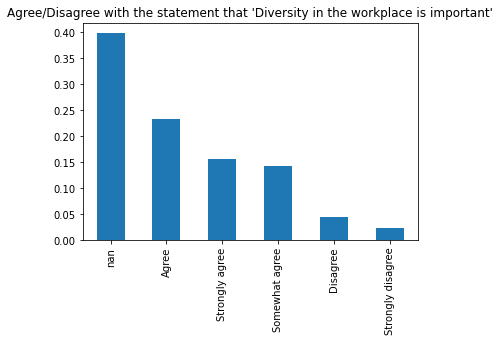

In [122]:
diversity_importance_value_counts = df_2017['DiversityImportant'].value_counts(dropna=False)
(diversity_importance_value_counts/df_2017.shape[0]).plot(kind="bar")
plt.title("Agree/Disagree with the statement that 'Diversity in the workplace is important'")

In [133]:
df_2017['DiversityImportant_missing'] = df_2017['DiversityImportant'].isna()

In [ ]:
diversity_imprtnt_strict_list = ["Strongly agree", "Agree"]
diversity_imprtnt_lax_list = ["Strongly agree", "Agree", "Somewhat agree"]
df_2017['DivImp_Strict']=df_2017['HomeRemote'].apply(collapse_cat_and_dummy, args=(diversity_imprtnt_strict_list,))
df_2017['DivImp_Lax']=df_2017['HomeRemote'].apply(collapse_cat_and_dummy, args=(diversity_imprtnt_lax_list,))

In [68]:
df_2017.groupby('HomeRemote')['JobSatisfaction'].mean()
df_2017['JobSatisfaction'].value_counts()

8.0     8983
7.0     7969
9.0     5573
6.0     4726
10.0    4148
5.0     3749
4.0     1865
3.0     1635
2.0      888
0.0      467
1.0      373
Name: JobSatisfaction, dtype: int64

In [ ]:
df_2017[['DeveloperType','WebDeveloperType','MobileDeveloperType','NonDeveloperType']].head()
# pd.__version__

In [71]:
df_2017.groupby(['CompanyType']).size()

CompanyType
Government agency or public school/university                             2451
I don't know                                                              3233
I prefer not to answer                                                    1816
Non-profit/non-governmental organization or private school/university     1225
Pre-series A startup                                                      1288
Privately-held limited company, not in startup mode                      16709
Publicly-traded corporation                                               5871
Sole proprietorship or partnership, not in startup mode                   2831
Something else                                                             342
State-owned company                                                        670
Venture-funded startup                                                    2387
dtype: int64

In [ ]:
def recode_null_not_null_as_0_1(df, cols_not_to_recode):
    '''
    This function will split the data frame into columns that can easily be
    recoded as 0/1, and those that cannot. More specifically, if a column
    has a single non-NaN string value, and the relevant information is already contained
    in the column name, then it will convert that column to a 0/1 dummy
    '''
    
    # Split the dataframe into columns that will be operated on, and those that won't
    df_recode = df.drop(columns = cols_not_to_recode)
    df = df[cols_not_to_recode]
    df_recode = df_recode.notnull().astype('int')
    df = pd.concat([df, df_recode], axis=1)
    return df

In [74]:
df_missingness_stats(df_2017, '2017')

Number of Rows in 2017 data: 51392
Number of Columns in 2017 data: 154
Number of Columns in 2017 data with no missing values: 7
Number of Columns in 2017 data with > 75% missing values: 14
Number of Columns in 2017 data with all missing values: 0
Columns in 2017 data with no missing values: {'ProgramHobby', 'Country', 'University', 'EmploymentStatus', 'FormalEducation', 'Professional', 'Respondent'}
Columns in 2017 data with > 75% missing values: {'WebDeveloperType', 'ExCoderReturn', 'ExCoderWillNotCode', 'ExCoderSkills', 'MobileDeveloperType', 'ExCoderActive', 'TimeAfterBootcamp', 'ExpectedSalary', 'ExCoderNotForMe', 'ExCoderBalance', 'NonDeveloperType', 'YearsCodedJobPast', 'ExCoderBelonged', 'ExCoder10Years'}


In [ ]:
df_2017['Professional'].value_counts()

In [77]:
df_2017['ProgramHobby'].value_counts()

Yes, I program as a hobby                    24801
Yes, both                                    13756
No                                            9787
Yes, I contribute to open source projects     3048
Name: ProgramHobby, dtype: int64

In [79]:
df_2017['University'].value_counts()

No                     37543
Yes, full-time          9369
Yes, part-time          3352
I prefer not to say     1128
Name: University, dtype: int64

In [81]:
df_2017['EmploymentStatus'].value_counts()

Employed full-time                                      36148
Independent contractor, freelancer, or self-employed     5233
Employed part-time                                       3180
Not employed, and not looking for work                   2791
Not employed, but looking for work                       2786
I prefer not to say                                      1086
Retired                                                   168
Name: EmploymentStatus, dtype: int64

In [ ]:
df_2017['FormalEducation'].value_counts()

In [84]:
df_2017['MajorUndergrad'].value_counts()

Computer science or software engineering                        21409
Computer engineering or electrical/electronics engineering       4364
Computer programming or Web development                          3883
Information technology, networking, or system administration     2140
A natural science                                                1865
A non-computer-focused engineering discipline                    1789
Mathematics or statistics                                        1648
Something else                                                   1060
A humanities discipline                                           901
A business discipline                                             900
Management information systems                                    654
Fine arts or performing arts                                      646
A social science                                                  633
I never declared a major                                          592
Psychology          

In [ ]:
df_2017['HomeRemote'].value_counts()

In [87]:
df_2017['CompanySize'].value_counts()

20 to 99 employees          8587
100 to 499 employees        7274
10,000 or more employees    5680
10 to 19 employees          4103
1,000 to 4,999 employees    3831
Fewer than 10 employees     3807
500 to 999 employees        2486
5,000 to 9,999 employees    1604
I don't know                 869
I prefer not to answer       681
Name: CompanySize, dtype: int64

In [89]:
df_2017['CompanyType'].value_counts()

Privately-held limited company, not in startup mode                      16709
Publicly-traded corporation                                               5871
I don't know                                                              3233
Sole proprietorship or partnership, not in startup mode                   2831
Government agency or public school/university                             2451
Venture-funded startup                                                    2387
I prefer not to answer                                                    1816
Pre-series A startup                                                      1288
Non-profit/non-governmental organization or private school/university     1225
State-owned company                                                        670
Something else                                                             342
Name: CompanyType, dtype: int64

In [91]:
df_2017['YearsProgram'].value_counts()

20 or more years    8817
4 to 5 years        3865
3 to 4 years        3701
5 to 6 years        3572
2 to 3 years        3251
9 to 10 years       3197
6 to 7 years        2869
1 to 2 years        2773
7 to 8 years        2466
10 to 11 years      2178
14 to 15 years      2011
8 to 9 years        1910
15 to 16 years      1669
Less than a year    1484
11 to 12 years      1389
12 to 13 years      1307
13 to 14 years      1092
16 to 17 years      1046
19 to 20 years      1021
17 to 18 years       879
18 to 19 years       648
Name: YearsProgram, dtype: int64

In [93]:
df_2017['YearsCodedJob'].value_counts()

1 to 2 years        5289
2 to 3 years        4767
3 to 4 years        4003
4 to 5 years        3405
20 or more years    3067
Less than a year    3034
5 to 6 years        2990
9 to 10 years       1956
6 to 7 years        1912
10 to 11 years      1678
7 to 8 years        1638
8 to 9 years        1287
15 to 16 years       845
14 to 15 years       840
11 to 12 years       838
12 to 13 years       741
16 to 17 years       694
17 to 18 years       545
13 to 14 years       531
19 to 20 years       427
18 to 19 years       403
Name: YearsCodedJob, dtype: int64

In [ ]:
df_2017['YearsCodedJobPast'].value_counts()

In [96]:
test = df_2017['DeveloperType'].str.split(";")
test.loc[test.isnull()] = test.loc[test.isnull()].apply(lambda x: []) 
test = test.apply(lambda x: sorted(x))

In [ ]:
test.head(20)

In [99]:
test1 = test.apply(pd.Series)

In [100]:
type(test1)

pandas.core.frame.DataFrame

In [101]:
test1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Desktop applications developer,Graphics programming,Mobile developer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
def create_dummy_df(df, cols_to_dummy, dummy_na=True):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in cols_to_dummy:
        try:
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], 
                                                                 prefix=col, 
                                                                 prefix_sep='_', 
                                                                 drop_first=True,
                                                                 dummy_na=dummy_na
                                                                )], axis=1)
        except:
            continue

    return df

In [103]:
#creating labelEncoder
def process_y_var_split_data(df, yvar):
    df[yvar] = df[yvar].str.replace('<', 'less than ')
    df[yvar] = df[yvar].str.replace('>', 'greater than ')
    df[yvar] = df[yvar].astype('str')
    df = df[df[yvar]!='nan']
    
    print(df[yvar].value_counts())
    le = preprocessing.LabelEncoder()
    X = df.drop(columns=[yvar])
    y = le.fit_transform(df[yvar])
    
    return X, y 


In [104]:
X_2013, y_2013 = process_y_var_split_data(df_2013, 'TotalCompensation')

NameError: name 'df_2013' is not defined

In [105]:
X_2014, y_2014 = process_y_var_split_data(df_2014, 'TotalCompensation')

NameError: name 'df_2014' is not defined

In [106]:
X_2015, y_2015 = process_y_var_split_data(df_2015, 'Compensation')

NameError: name 'df_2015' is not defined

In [107]:
# Split dataset into training set and test set
def compare_classifiers(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42) # 70% training and 30% test


    #Create a Gaussian Classifier
    gnb = GaussianNB()

    #Train the model using the training sets
    gnb.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred_gnb = gnb.predict(X_test)

    # Logistic Regression Classifier
    logreg = LogisticRegression()

    #Train the model using the training sets
    logreg.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred_lr = logreg.predict(X_test)

    # Random Forest Classifier
    rf = RandomForestClassifier()

    #Train the model using the training sets
    rf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred_rf = rf.predict(X_test)

    # Adaboost Classifier
    ada = AdaBoostClassifier()

    #Train the model using the training sets
    ada.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred_ada = ada.predict(X_test)

    print("GNB Accuracy:",metrics.accuracy_score(y_test, y_pred_gnb))

    print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, y_pred_lr))

    print("Random Forest Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))

    print("AdaBoost Accuracy:",metrics.accuracy_score(y_test, y_pred_ada))


In [108]:
# Split dataset into training set and test set
def compare_classifiers(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42) # 70% training and 30% test

    #Create a Gaussian Classifier
    gnb = GaussianNB()

    #Train the model using the training sets
    gnb.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred_gnb = gnb.predict(X_test)

    # Logistic Regression Classifier
    logreg = LogisticRegression()

    #Train the model using the training sets
    logreg.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred_lr = logreg.predict(X_test)

    # Random Forest Classifier
    rf = RandomForestClassifier()

    #Train the model using the training sets
    rf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred_rf = rf.predict(X_test)

    # Adaboost Classifier
    ada = AdaBoostClassifier()

    #Train the model using the training sets
    ada.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred_ada = ada.predict(X_test)

    print("GNB Accuracy:",metrics.accuracy_score(y_test, y_pred_gnb))

    print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, y_pred_lr))

    print("Random Forest Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))

    print("AdaBoost Accuracy:",metrics.accuracy_score(y_test, y_pred_ada))

In [109]:
compare_classifiers(X_2014, y_2014)

NameError: name 'X_2014' is not defined

In [110]:
compare_classifiers(X_2015, y_2015)

NameError: name 'X_2015' is not defined

In [111]:
# pp.pprint(crd.column_name_map_2014)

In [112]:
# pp.pprint(list(df_2014.columns))

In [113]:
def plot_value_counts(df, col, plot_title):
    status_vals = df[col].value_counts() 
    print(status_vals)
    # The below is a bar chart of the proportion of observations in each category of df[col]
    (status_vals/df.shape[0]).plot(kind="bar");
    plt.title("What kind of developer are you?");

In [114]:
def get_description(column_name, schema=schema):
    '''
    INPUT - schema - pandas dataframe with the schema of the developers survey
            column_name - string - the name of the column you would like to know about
    OUTPUT - 
            desc - string - the description of the column
    '''
    desc = schema['Question'][schema['Column']==column_name].values[0]
    return desc

NameError: name 'schema' is not defined

In [115]:
possible_vals = ["Take online courses", "Buy books and work through the exercises", 
                 "None of these", "Part-time/evening courses", "Return to college",
                 "Contribute to open source", "Conferences/meet-ups", "Bootcamp",
                 "Get a job as a QA tester", "Participate in online coding competitions",
                 "Master's degree", "Participate in hackathons", "Other"]

def clean_and_plot(df, title='Method of Educating Suggested', plot=True):
    '''
    INPUT 
        df - a dataframe holding the CousinEducation column
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        study_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CousinEducation column.
    '''
    study = df['CousinEducation'].value_counts().reset_index()
    study.rename(columns={'index': 'method', 'CousinEducation': 'count'}, inplace=True)
    study_df = t.total_count(study, 'method', 'count', possible_vals)

    study_df.set_index('method', inplace=True)
    if plot:
        (study_df/study_df.sum()).plot(kind='bar', legend=None);
        plt.title(title);
        plt.show()
    props_study_df = study_df/study_df.sum()
    return props_study_df
    
props_df = clean_and_plot(df)

NameError: name 'df' is not defined